In [1]:
from typing import Any

import numpy as np
# import numpy.typing as npt

import pandas as pd
from mapie.subsample import BlockBootstrap
from pmdarima.metrics import smape

from scipy.stats import randint, norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_pinball_loss
from statsmodels.tools.eval_measures import rmse
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from uncertainty_toolbox.metrics_scoring_rule import nll_gaussian
# from properscoring import crps_ensemble

# from compare_methods import UQ_Comparer
from helpers import get_data, IO_Helper

from conformal_prediction import (train_base_model as train_base_model_cp, estimate_pred_interals_no_pfit_enbpi)
from quantile_regression import estimate_quantiles as estimate_quantiles_qr

import torch

from laplace import Laplace

In [12]:
import copy
import os
from abc import ABC, abstractmethod
from typing import Optional, Any

import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt

from helpers import starfilter, is_ascending


# todo: add type hints
# noinspection PyPep8Naming
class UQ_Comparer(ABC):
    # todo: After these required inputs, they may accept any args or kwargs you wish.
    """
    Usage:
    1. Inherit from this class.
    2. Override get_data, compute_metrics, and train_base_model.
    3. Define all desired posthoc and native UQ methods. The required signature is:
            (X_train, y_train, X_test, quantiles) -> (y_pred, y_quantiles, y_std)
       Posthoc methods receive an additional base_model parameter, so their signature looks like:
            (..., quantiles, base_model, *args, **kwargs) -> (y_pred, ...)
       All posthoc and native UQ method names should start with 'posthoc_' and 'native_', respectively. They should
       all be instance methods, not class or static methods.
    4. Call compare_methods from the child class
    """

    def __init__(self, method_whitelist=None):
        # todo: store train and test data once loaded
        self.method_whitelist = method_whitelist

    def compare_methods(self, quantiles, should_plot_data=True, should_plot_results=True, should_save_plots=True, plots_path=".", return_results=False, skip_deepcopy=False, base_model_params=None, output_uq_on_train=True) -> tuple[dict, dict] | dict[str, dict[str, dict[str, Any]]]:
        # todo: improve, e.g. tuple[dict[str, tuple[np.array, np.array]], dict[str, tuple[np.array, np.array]]]
        """
        :param base_model_params:
        :param skip_deepcopy:
        :param plots_path:
        :param should_save_plots:
        :param quantiles:
        :param should_plot_data:
        :param should_plot_results:
        :param return_results: return native and posthoc results in addition to the native and posthoc metrics?
        :param output_uq_on_train: whether to produce results for X_train, too. Output for X_test is always produced.
        :return: UQ metrics and UQ results if return_results is False, else UQ metrics also native and posthoc results
        """
        print("loading data")
        X_train, X_test, y_train, y_test, X, y = self.get_data()
        print("data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        if should_plot_data:
            print("plotting data")
            plot_data(X_train, X_test, y_train, y_test, save_plot=should_save_plots, plots_path=plots_path)

        print("running UQ methods")
        X_uq = np.row_stack((X_train, X_test)) if output_uq_on_train else X_test
        uq_results = self.run_all_methods(X_train, y_train, X_uq, quantiles=quantiles, skip_deepcopy=skip_deepcopy, base_model_params=base_model_params)

        if should_plot_results:
            print("plotting native vs posthoc results")
            plot_uq_results_all(X_train, y_train, X_test, y, uq_results, quantiles, output_uq_on_train, save_plots=should_save_plots, plots_path=plots_path)

        y_uq = y if output_uq_on_train else y_test
        print("computing and comparing metrics")
        uq_metrics = {
            uq_type: self.compute_all_metrics(methods_results, y_uq, quantiles=quantiles)
            for uq_type, methods_results in uq_results.items()
        }
        if return_results:
            return uq_metrics, uq_results
        return uq_metrics

    # todo: make classmethod?
    @abstractmethod
    def get_data(self) -> tuple[
        npt.NDArray[float], npt.NDArray[float], npt.NDArray[float], npt.NDArray[float], npt.NDArray[float], npt.NDArray[float], ]:
        """

        :return: X_train, X_test, y_train, y_test, X, y
        """
        raise NotImplementedError

    # todo: make classmethod?
    @abstractmethod
    def compute_metrics(self, y_pred, y_quantiles: Optional[npt.NDArray], y_std: Optional[npt.NDArray], y_true, quantiles):
        """
        Evaluate a UQ method by compute all desired metrics.

        :param y_pred:
        :param y_quantiles: array of shape (n_samples, n_quantiles) containing the predicted quantiles of y_true
        :param y_std: 1D array-like of predicted standard deviations around y_true
        :param y_true:
        :param quantiles: list of quantiles with which test to measure performance. They are expected to be symmetric
        :return:
        """
        raise NotImplementedError

    # todo: make classmethod?
    def compute_all_metrics(self, uq_results: dict[
            str, tuple[
                npt.NDArray[float], Optional[npt.NDArray[float]], Optional[npt.NDArray[float]], ], ], y_true, quantiles=None):
        """

        :param quantiles: quantiles
        :param uq_results: dict of (method_name, (y_pred, y_quantiles, y_std))
        :param y_true:
        :return:
        """
        return {
            method_name: self.compute_metrics(y_pred, y_quantiles, y_std, y_true, quantiles=quantiles
            )
            for method_name, (y_pred, y_quantiles, y_std) in uq_results.items()
        }

    @abstractmethod
    def train_base_model(self, X_train, y_train):
        raise NotImplementedError

    @classmethod
    def get_posthoc_methods(cls):
        return cls._get_uq_methods_by_type("posthoc")

    @classmethod
    def get_native_methods(cls):
        return cls._get_uq_methods_by_type("native")

    def _get_uq_methods_by_type(self, uq_type: str):
        """

        :param uq_type: one of "native", "posthoc"
        :return: all instance methods (i.e. callable attributes) with prefix given by uq_type
        """
        for attr_name in self.__class__.__dict__.keys():
            attr = getattr(self, attr_name)
            if attr_name.startswith(uq_type) and callable(attr):
                yield attr_name, attr

    def run_all_methods(self, X_train, y_train, X_uq, quantiles, skip_deepcopy=False, base_model_params=None):
        """

        :param X_train:
        :param y_train:
        :param X_uq:
        :param quantiles:
        :param skip_deepcopy:
        :param base_model_params:
        :return: dict of results: {'posthoc': posthoc_results, 'native': native_results\
        """
        uq_results = {}
        for uq_type in ["posthoc", "native"]:
            uq_result = self._run_methods(X_train, y_train, X_uq, quantiles=quantiles, uq_type=uq_type, skip_deepcopy=skip_deepcopy, base_model_params=base_model_params)
            uq_results[uq_type] = uq_result
        return uq_results

    def _run_methods(self, X_train, y_train, X_uq, quantiles, *, uq_type, skip_deepcopy=False, base_model_params: dict = None, output_uq_on_train=True) -> dict[str, tuple[npt.NDArray[float], npt.NDArray[float], npt.NDArray[float]]]:
        """

        :param base_model_params:
        :param skip_deepcopy: whether to skip making a deepcopy of the base model. speed up execution, but can lead to
         bugs if posthoc method affects the base model object. ignored for native methods
        :param X_train:
        :param y_train:
        :param X_uq:
        :param uq_type: one of: "posthoc", "native"
        :return: dict of (method_name, (y_pred, y_quantiles)), where y_pred and y_quantiles are 1D and 2D, respectively
        """
        assert uq_type in ["posthoc", "native"]
        is_posthoc = uq_type == "posthoc"
        if is_posthoc:
            print("training base model")
            if base_model_params is None:
                base_model_params = {}
            base_model = self.train_base_model(X_train, y_train, **base_model_params)
        print(f"running {uq_type} methods")
        uq_methods = self._get_uq_methods_by_type(uq_type)
        if self.method_whitelist is not None:
            uq_methods = starfilter(lambda name, _: name in self.method_whitelist, uq_methods
            )

        uq_results = {}
        for method_name, method in uq_methods:
            if is_posthoc:
                # noinspection PyUnboundLocalVariable
                base_model_copy = (copy.deepcopy(base_model) if not skip_deepcopy else base_model
                )
                y_pred, y_quantiles, y_std = method(X_train, y_train, X_uq, quantiles, base_model_copy
                )
            else:
                y_pred, y_quantiles, y_std = method(X_train, y_train, X_uq, quantiles)
            uq_results[method_name] = y_pred, y_quantiles, y_std
        return uq_results

    @staticmethod
    def stds_from_quantiles(quantiles: npt.NDArray):
        """
        :param quantiles: array of shape (number of datapoints, number of quantiles), where number of quantiles should
        be at least about 100
        :return:
        """
        num_quantiles = quantiles.shape[1]
        if num_quantiles < 50:
            print(f"warning: {num_quantiles} quantiles are too few to compute a reliable std from (should be about 100)"
            )
        return np.std(quantiles, ddof=1, axis=1)

    @staticmethod
    def pis_from_quantiles(quantiles):
        mid = len(quantiles) // 2
        first, second = quantiles[:mid], quantiles[mid:]
        pi_limits = zip(first, reversed(second))
        pis = [high - low for low, high in pi_limits]
        return sorted(pis)

    @staticmethod
    def quantiles_from_pis(pis: npt.NDArray, check_order=False):
        """
        currently "buggy" for odd number of quantiles.
        :param check_order:
        :param pis: prediction intervals array of shape (n_samples, 2, n_intervals)
        :return: array of quantiles of shape (n_samples, 2 * n_intervals)
        """
        # todo: assumption that quantile ordering is definitely consistant fulfilled?
        if check_order:
            assert np.all([is_ascending(pi[0, :], reversed(pi[1, :])) for pi in pis])
        y_quantiles = np.array([sorted(pi.flatten()) for pi in pis])
        return y_quantiles

    @staticmethod
    def optional(func):
        # todo
        """
        :param func:
        :return:
        """

        def optional_func(*args, **kwargs):
            # todo: needed?
            pass


# PLOTTING


def plot_data(X_train, X_test, y_train, y_test, figsize=(16, 5), ylabel="energy data",  # todo: details!
    save_plot=True, filename="data.png", plots_path="."):
    """visualize training and test sets"""
    num_train_steps = X_train.shape[0]
    num_test_steps = X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_test = x_plot_train + num_test_steps

    plt.figure(figsize=figsize)
    plt.plot(x_plot_train, y_train)
    plt.plot(x_plot_test, y_test)
    plt.ylabel(ylabel)
    plt.legend(["Training data", "Test data"])
    if save_plot:
        filepath = os.path.join(plots_path, filename)
        plt.savefig(filepath)
    plt.show()


def plot_uq_results_all(X_train, y_train, X_test, y, uq_results, quantiles, output_uq_on_train: bool, save_plots=True, plots_path="."):
    for res_type, results in uq_results.items():
        if results:
            print(f"plotting {res_type} results...")
        else:
            continue
        # todo: allow results to have multiple PIs (corresp. to multiple alphas)?
        for method_name, (y_preds, y_quantiles, y_std) in results.items():
            if y_quantiles is None and y_std is None:
                print(f"warning: cannot plot method {method_name}, because both y_quantiles and y_std are None"
                )
                continue
            uq_type, *method_name_parts = method_name.split("_")
            plot_uq_result(X_train, X_test, y_train, y, y_preds, y_quantiles, y_std, quantiles, output_uq_on_train, plot_name=" ".join(method_name_parts), uq_type=uq_type, save_plot=save_plots, plots_path=plots_path)


def plot_uq_result(X_train, X_test, y_train, y, y_preds, y_quantiles, y_std, quantiles, output_uq_on_train, plot_name, uq_type, save_plot=True, plots_path="."):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = x_plot_train + num_test_steps  # shifting
    x_plot_uq = x_plot_full if output_uq_on_train else x_plot_test

    drawing_std = y_quantiles is not None
    if drawing_std:
        ci_low, ci_high = (y_quantiles[:, 0], y_quantiles[:, -1])
        drawn_quantile = round(max(quantiles) - min(quantiles), 2)
    else:
        ci_low, ci_high = y_preds - y_std / 2, y_preds + y_std / 2

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points")
    ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction {plot_name}",  # todo: mean or median?
        color="green")
    # noinspection PyUnboundLocalVariable
    label = rf"{plot_name} {f'{100*drawn_quantile}% CI' if drawing_std else '1 std'}"
    ax.fill_between(x_plot_uq.ravel(), ci_low, ci_high, color="green", alpha=0.2, label=label)
    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")
    ax.set_title(f"{plot_name} ({uq_type})")
    if save_plot:
        filename = f"{plot_name}_{uq_type}.png"
        filepath = os.path.join(plots_path, filename)
        plt.savefig(filepath)
    plt.show()

In [3]:
METHOD_WHITELIST = [
    # "posthoc_conformal_prediction", # "posthoc_laplace", # "native_quantile_regression", "native_gp",
]
QUANTILES = [0.05, 0.25, 0.75, 0.95]  # todo: how to handle 0.5? ==> just use mean if needed

PLOT_DATA = False
PLOT_RESULTS = True  # todo: fix plotting timing?
SAVE_PLOTS = True

PLOTS_PATH = "plots"

BASE_MODEL_PARAMS = {
    'skip_training': True, # 'n_jobs': -1, # 'model_params_choices': None,
}

torch.set_default_dtype(torch.float32)


def print_metrics(uq_metrics: dict[str, dict[str, dict[str, Any]]]):
    for uq_type, method_metrics in uq_metrics.items():
        print(f'{uq_type} metrics:')
        for method, metrics in method_metrics.items():
            print(f'\t{method}:')
            for metric, value in metrics.items():
                print(f'\t\t{metric}: {value}')

In [4]:
def main():
    uq_comparer = My_UQ_Comparer(method_whitelist=METHOD_WHITELIST)
    uq_metrics = uq_comparer.compare_methods(QUANTILES,should_plot_data=PLOT_DATA,should_plot_results=PLOT_RESULTS,should_save_plots=SAVE_PLOTS,plots_path=PLOTS_PATH,base_model_params=BASE_MODEL_PARAMS,output_uq_on_train=True,return_results=False,)
    print_metrics(uq_metrics)

In [5]:
class My_UQ_Comparer(UQ_Comparer):
    def __init__(self, storage_path='comparison_storage', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.io_helper = IO_Helper(storage_path)

    # todo: remove param?
    def get_data(self, _n_points_per_group=100):
        return get_data(_n_points_per_group, return_full_data=True)

    # todo: type hints!
    def compute_metrics(self, y_pred, y_quantiles, y_std, y_true, quantiles=None):
        y_true_np = y_true.to_numpy().squeeze()
        # todo: sharpness? calibration? PIT? coverage?
        # todo: skill score (but what to use as benchmark)?

        metrics = {  # todo: improve
            "rmse": rmse(y_true_np, y_pred), "smape": smape(y_true_np, y_pred) / 100,  # scale down to [0, 1]
            "crps": (# todo: implement
                None  # crps_ensemble(y_pred, y_std, y_true_np) if y_std is not None else None
            ), "neg_log_lik": (nll_gaussian(y_pred, y_std, y_true_np) if y_std is not None else None
            ), "mean_pinball": (self._mean_pinball_loss(y_pred, y_quantiles, quantiles)
                if y_quantiles is not None
                else None
            ), }
        return metrics

    @staticmethod
    def _mean_pinball_loss(y_true, y_quantiles, quantiles):
        return np.mean([
                mean_pinball_loss(y_true, y_quantiles[:, ind], alpha=quantile)
                for ind, quantile in enumerate(quantiles)
            ]
        )

    def train_base_model(self, X_train, y_train, model_params_choices=None, skip_training=True, n_jobs=-1):
        # todo: more flexibility in choosing (multiple) base models
        if model_params_choices is None:
            model_params_choices = {
                "max_depth": randint(2, 30), "n_estimators": randint(10, 100), }
        return train_base_model_cp(RandomForestRegressor, model_params_choices=model_params_choices, X_train=X_train, y_train=y_train, skip_training=skip_training, cv_n_iter=10, n_jobs=n_jobs, io_helper=self.io_helper
        )

    def train_base_model2(self, X_train: pd.DataFrame, y_train: pd.DataFrame, model_params_choices=None, n_epochs=1000, batch_size=1, random_state=711, verbose=True, skip_training=True, save_trained=True, model_filename="_laplace_base.pth"):
        """

        :param model_filename:
        :param save_trained:
        :param skip_training:
        :param verbose:
        :param X_train: shape (n_samples, n_dims)
        :param y_train: shape (n_samples, n_dims)
        :param model_params_choices:
        :param n_epochs:
        :param batch_size:
        :param random_state:
        :return:
        """
        # todo: more flexibility in choosing (multiple) base models
        torch.manual_seed(random_state)

        dim_in, dim_out = X_train.shape[-1], y_train.shape[-1]
        model = torch.nn.Sequential(torch.nn.Linear(dim_in, 50), torch.nn.Tanh(), torch.nn.Linear(50, dim_out)
        ).float()

        if skip_training:
            print("skipping base model training")
            try:
                model = self.io_helper.load_torch_model(model_filename, weights_only=False)
                model.eval()
                return model
            except FileNotFoundError:
                # todo
                print("error. model not found, so training cannot be skipped. training from scratch"
                )

        # todo: consistent input expectations!
        train_loader = self._get_train_loader(X_train, y_train, batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        iterable = tqdm(range(n_epochs)) if verbose else range(n_epochs)
        for _ in iterable:
            for X, y in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(X), y)
                loss.backward()
                optimizer.step()
        if save_trained:
            torch.save(model, model_filename)
        model.eval()
        return model

    def posthoc_conformal_prediction(self, X_train, y_train, X_test, quantiles, model, random_state=42
    ):
        cv = BlockBootstrap(n_resamplings=10, n_blocks=10, overlapping=False, random_state=random_state
        )
        alphas = self.pis_from_quantiles(quantiles)
        y_pred, y_pis = estimate_pred_interals_no_pfit_enbpi(model, cv, alphas, X_test, X_train, y_train, skip_base_training=True, io_helper=self.io_helper
        )
        # todo!
        y_quantiles = self.quantiles_from_pis(y_pis)
        y_std = None  # self.stds_from_quantiles(y_quantiles)
        return y_pred, y_quantiles, y_std

    def posthoc_laplace(self, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, quantiles, model, n_epochs=1000, batch_size=1, random_state=711, verbose=True):
        # todo: offer option to alternatively optimize parameters and hyperparameters of the prior jointly (cf. example
        #  script)?
        train_loader = self._get_train_loader(X_train, y_train, batch_size)

        la = Laplace(model, "regression")
        la.fit(train_loader)
        log_prior, log_sigma = (torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True))
        hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
        iterable = tqdm(range(n_epochs)) if verbose else range(n_epochs)
        for _ in iterable:
            hyper_optimizer.zero_grad()
            neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
            neg_marglik.backward()
            hyper_optimizer.step()

        # # Serialization for fitted quantities
        # state_dict = la.state_dict()
        # torch.save(state_dict, "state_dict.bin")
        #
        # la = Laplace(model, "regression", subset_of_weights="all", hessian_structure="full")
        # # Load serialized, fitted quantities
        # la.load_state_dict(torch.load("state_dict.bin"))

        X_test = self._df_to_tensor(X_test)
        f_mu, f_var = la(X_test)

        f_mu = f_mu.squeeze().detach().cpu().numpy()
        f_sigma = f_var.squeeze().detach().sqrt().cpu().numpy()
        pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item() ** 2)

        y_pred, y_std = f_mu, pred_std
        y_quantiles = self.quantiles_gaussian(quantiles, y_pred, y_std)
        return y_pred, y_quantiles, y_std

    def native_quantile_regression(self, X_train, y_train, X_test, quantiles):
        y_pred, y_quantiles = estimate_quantiles_qr(X_train, y_train, X_test, alpha=quantiles
        )
        y_std = self.stds_from_quantiles(y_quantiles)
        return y_pred, y_quantiles, y_std

    # noinspection PyMethodMayBeStatic
    # todo: make static?
    def native_gp(self, X_train, y_train, X_test, quantiles):
        kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200
        )
        gaussian_process.fit(X_train, y_train)

        mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True
        )
        y_pred, y_std = mean_prediction, std_prediction
        y_quantiles = self.quantiles_gaussian(quantiles, y_pred, y_std)
        return y_pred, y_quantiles, y_std

    @staticmethod
    def _df_to_tensor(df: pd.DataFrame, dtype=float) -> torch.Tensor:
        return torch.Tensor(df.to_numpy(dtype=dtype))

    @classmethod
    def _get_train_loader(cls, X_train, y_train, batch_size):
        X_train, y_train = map(lambda df: cls._df_to_tensor(df, dtype=float), (X_train, y_train)
        )
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size)
        return train_loader

    @staticmethod
    def quantiles_gaussian(quantiles, y_pred, y_std):
        # todo: does this work for multi-dim outputs?
        return np.array([norm.ppf(quantiles, loc=mean, scale=std)
                                for mean, std in zip(y_pred, y_std)])

In [7]:
quantiles = QUANTILES
_n_points_per_group = 100
X_train, X_test, y_train, y_test, X, y = get_data(_n_points_per_group, return_full_data=True)

fitting GP
predicting with GP
plot results
plotting native results...


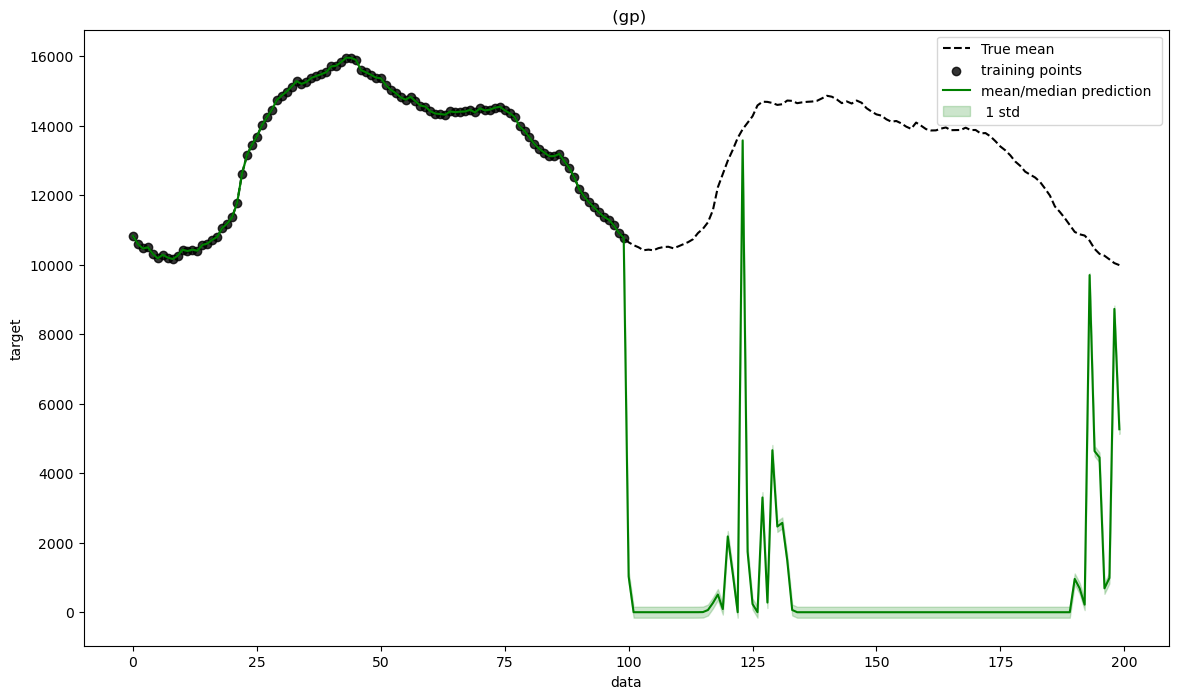

In [8]:
print('fitting GP')
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200)
gaussian_process.fit(X_train, y_train)
print('predicting with GP')
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
uq_results = {'native': {'gp': (mean_prediction, None, std_prediction)}}

print('plot results')
output_uq_on_train = True
plots_path = '.'
plot_uq_results_all(X_train, y_train, X_test, y, uq_results, quantiles, output_uq_on_train, save_plots=False, plots_path=plots_path)

fitting...
done


1.34e+04**2 + 1.4e+03**2 * RBF(length_scale=0.119) + WhiteKernel(noise_level=1.57e+06)

predicting with GP
plotting native results...


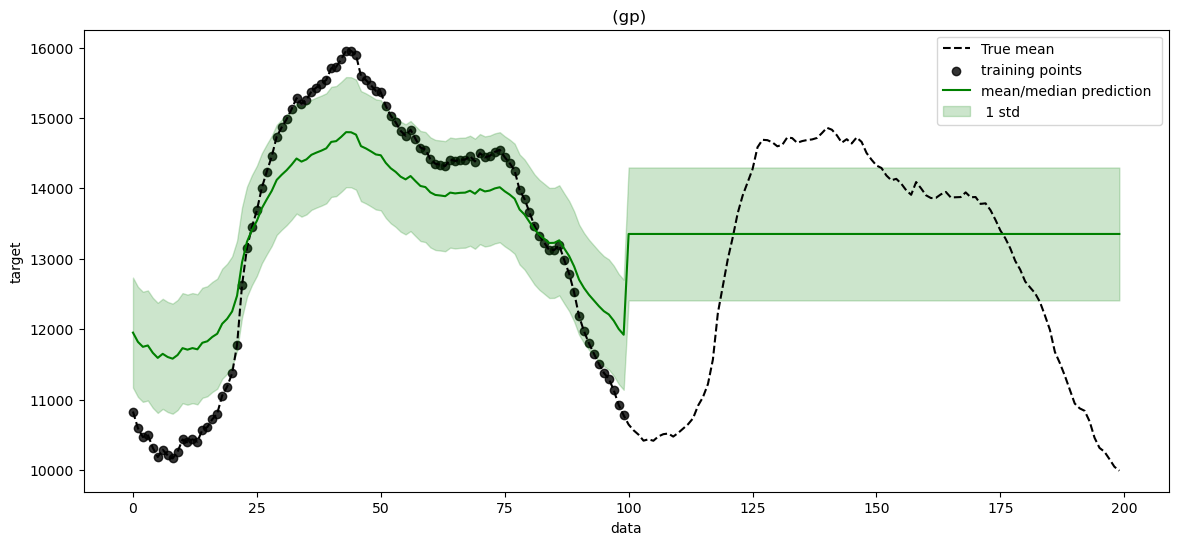

In [62]:
from sklearn.gaussian_process import kernels as kernels



# output_shift, output_shift_bounds = 13_000, (10_000, 20_000)
# output_scale, output_scale_bounds = 5000, (5000, 40000)
# rbf_scale, rbf_scale_bounds = 100, (10, 500)
# noise_scale, noise_scale_bounds = 100, (0.1, 1000)


output_shift, output_shift_bounds = 1, (1e-6, 1e6)
output_scale, output_scale_bounds = 1, (1e-6, 1e6)
rbf_scale, rbf_scale_bounds = 1, (1e-6, 1e6)
noise_scale, noise_scale_bounds = 1, (1e-6, 1e6)


def kernelize(kernel, value, bounds):
    return kernel(value**2, (bounds[0]**2, bounds[1]**2))

kernel = (
    kernelize(kernels.ConstantKernel, output_shift, output_shift_bounds)
    + kernelize(kernels.ConstantKernel, output_scale, output_scale_bounds)
      * kernelize(kernels.RBF, rbf_scale, rbf_scale_bounds)
    + kernelize(kernels.WhiteKernel, noise_scale, noise_scale_bounds)
)


# kernel = (
#     kernels.ConstantKernel(constant_value=1.0 ** 2,
#                            constant_value_bounds=(1e-05, 1e5))
#     + 
#       kernels.ConstantKernel(constant_value=1.0 ** 2,
#                              constant_value_bounds=(1e-05, 1e5))
#       * 
#       kernels.RBF(length_scale=1.0 ** 2,
#                     length_scale_bounds=(1e-3, 1e3))
#     + kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-05, 4e4))
# )


gaussian_process = GaussianProcessRegressor(kernel=kernel, random_state=0, normalize_y=False, n_restarts_optimizer=10)

print('fitting...')
gaussian_process = gaussian_process.fit(X_train, y_train)
print('done')
display(gaussian_process.kernel_)

print('predicting with GP')
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
uq_results = {'native': {'gp': (mean_prediction, None, std_prediction)}}

plot_uq_results_all(X_train, y_train, X_test, y, uq_results, quantiles, output_uq_on_train=True, save_plots=False, plots_path='.')

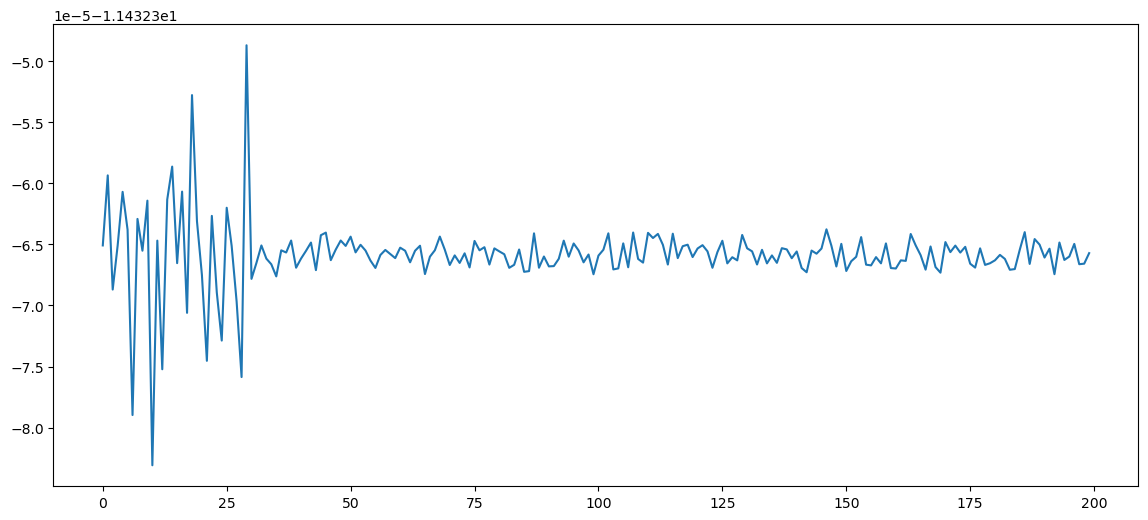

In [92]:
from sklearn.gaussian_process import kernels as kernels

n_samples = 3
random_state = None

output_shift, output_shift_bounds = 13_000, (10_000, 20_000)
output_scale, output_scale_bounds = 5000, (5000, 40000)
rbf_scale, rbf_scale_bounds = 100, (10, 500)
noise_scale, noise_scale_bounds = 10, (0.1, 1000)


def kernelize(kernel, value, bounds):
    return kernel(value**2, (bounds[0]**2, bounds[1]**2))

kernel = (
    kernelize(kernels.ConstantKernel, output_shift, output_shift_bounds)
    + kernelize(kernels.ConstantKernel, output_scale, output_scale_bounds)
      * kernelize(kernels.RBF, rbf_scale, rbf_scale_bounds)
    + kernelize(kernels.WhiteKernel, noise_scale, noise_scale_bounds)
)

kernel = kernels.ConstantKernel(42)
n_samples = 1
random_state = 0

gp = GaussianProcessRegressor(kernel=kernel, random_state=0, normalize_y=False, n_restarts_optimizer=10)
samples = gp.sample_y(X, n_samples=n_samples, random_state=random_state)

# pred = gp.predict(X, return_std=True)

x_plot = np.arange(X.shape[0])
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(x_plot, samples)
plt.show()
# ax.plot(x_plot, y)

In [93]:
samples

array([[-11.43236508],
       [-11.43235934],
       [-11.43236869],
       [-11.43236508],
       [-11.43236069],
       [-11.43236379],
       [-11.43237898],
       [-11.43236291],
       [-11.43236551],
       [-11.43236141],
       [-11.43238309],
       [-11.43236469],
       [-11.43237523],
       [-11.43236132],
       [-11.43235862],
       [-11.43236653],
       [-11.43236067],
       [-11.4323706 ],
       [-11.43235276],
       [-11.43236309],
       [-11.4323675 ],
       [-11.43237453],
       [-11.43236266],
       [-11.43236893],
       [-11.43237287],
       [-11.43236199],
       [-11.43236512],
       [-11.43236967],
       [-11.43237586],
       [-11.43234868],
       [-11.43236782],
       [-11.43236651],
       [-11.43236508],
       [-11.43236616],
       [-11.43236662],
       [-11.43236762],
       [-11.43236548],
       [-11.43236566],
       [-11.43236468],
       [-11.4323669 ],
       [-11.43236615],
       [-11.43236552],
       [-11.43236484],
       [-11

# section

---

In [7]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

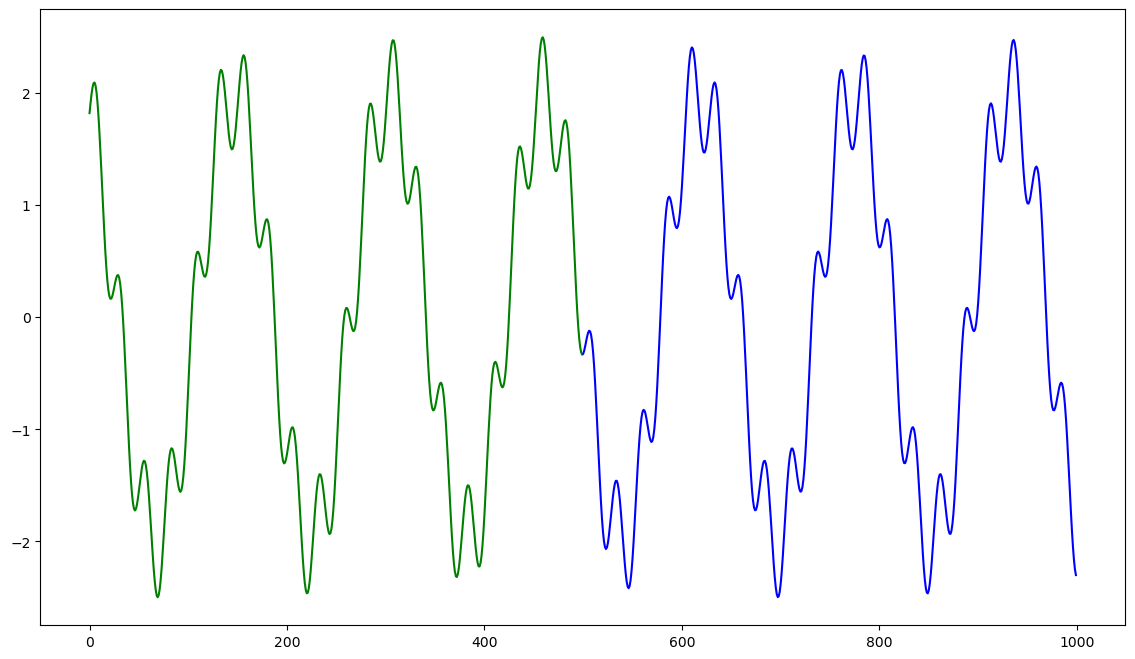

In [47]:
n_samples = 1000
n_dim = 1
X = np.arange(n_dim * n_samples).reshape(-1, n_dim)
periods = (4, 25)
y = np.mean(
    + 0
    # + 5 * X / max(X)
    + 1/2 * np.sin(X / periods[0])
    + 2   * np.sin(X / periods[1] + 2)
    # + 3   * np.sin(1 / (X + 1))
    , axis=-1
)

split = n_samples//2
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.plot(X_train, y_train, color='green')
ax.plot(X_test, y_test, color='blue')
plt.show()

In [51]:
y_mat = y.reshape(-1,1)
np.column_stack(list(zip((y_mat[periods[0]:], y_mat[periods[1]:]))))

array([[[ 2.08350241],
        [ 2.09148512],
        [ 2.06737934],
        ...,
        [-2.16129052],
        [-2.24687828],
        [-2.29957562]]])

In [29]:
from sklearn.gaussian_process import kernels as kernels

kernel = (
    kernels.ConstantKernel(constant_value=1.0 ** 2,
                           constant_value_bounds=(1e-05, 1e5))
    + kernels.ConstantKernel(constant_value=1.0 ** 2,
                             constant_value_bounds=(1e-05, 1e5))
      * kernels.RBF(length_scale=1.0 ** 2,
                    length_scale_bounds=(1e-3, 1e3))
)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, normalize_y=False, n_restarts_optimizer=10)

print('fitting...')
gpr = gpr.fit(X_train, y_train)
print('done')
gpr.kernel_

fitting...
done


GaussianProcessRegressor(kernel=1**2 + 1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, random_state=0)

In [35]:
gpr.kernel_

0.272**2 + 19.3**2 * RBF(length_scale=25.1)

predicting...
done.
plotting results


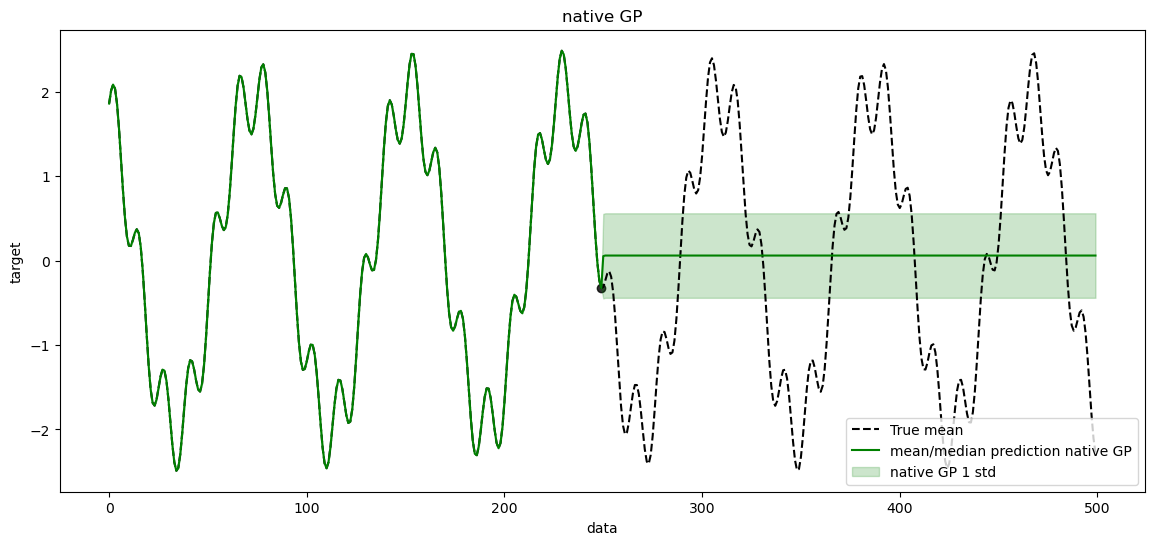

In [26]:
print('predicting...')
means, stds = gpr.predict(X, return_std=True)
y_preds, y_std = means, stds
print('done.')

print('plotting results')
num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

x_plot_train = np.arange(num_train_steps)
x_plot_full = np.arange(num_train_steps + num_test_steps)
x_plot_uq = x_plot_full

ci_low, ci_high = y_preds - y_std / 2, y_preds + y_std / 2
plot_name = 'native GP'
label = rf"{plot_name} 1 std"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
ax.scatter(x_plot_train[-1], y_train[-1], color="black", marker="o", alpha=0.8)
# ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points")
ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction {plot_name}", color="green")

ax.fill_between(x_plot_uq.ravel(), ci_low, ci_high, color="green", alpha=0.2, label=label)

ax.legend()
ax.set_xlabel("data")
ax.set_ylabel("target")
ax.set_title(f"{plot_name}")
plt.show()